In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union, Dict

plt.style.use('seaborn-whitegrid')
np.set_printoptions(precision=6, suppress = True)
pd.options.display.float_format = '{:.6f}'.format

In [2]:
def r_squared(y_true, y_pred):
    return y_pred.var()/y_true.var()

def sum_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

def DurbinWatson(eps):
    return ((eps[1:] - eps[:-1])**2).sum()/(eps**2).sum()

def ModelEstimation(y_true, y_pred):
    N = len(y_pred)
    return pd.Series({
        'R-squared': r_squared(y_true, y_pred),
        'Sum squared resid': sum_squared_error(y_true, y_pred),
        'Durbin-Watson stat': DurbinWatson(y_pred - y_true),
    })

### Завантаження даних

In [3]:
RSAFSNA = pd.read_csv('./lab4_data/RSAFSNA.txt', squeeze=True, header=None, names=['RSAFSNA'])
CURRNS = pd.read_csv('./lab4_data/CURRNS.txt', squeeze=True, header=None, names=['CURRNS'])

In [4]:
print(f'RSAFSNA length = {len(RSAFSNA)}')
print(f'CURRNS length = {len(CURRNS)}')

RSAFSNA length = 200
CURRNS length = 740


In [5]:
def train_test_split(series: pd.Series, test_size: Union[int, float]=0.2) -> tuple[pd.Series, pd.Series]:
    if type(test_size) is float:
        if test_size >=1 or test_size <= 0:
            raise ValueError('float test_size must be in range (0, 1)')
        train_len = int(len(series)*(1-test_size))
    elif type(test_size) is int:
        if test_size >= len(series) or test_size <=0:
            raise ValueError('int test_size must be in range (0, len(series))')
        train_len = len(series) - test_size
    else:
        raise ValueError('test_size must be int or float')
    train, test = series[:train_len], series[train_len:]
    train.name += ' train'
    test.name += ' test'
    return series[:train_len], series[train_len:]

In [6]:
RSAFSNA_train, RSAFSNA_test = train_test_split(RSAFSNA, test_size=8)
CURRNS_train, CURRNS_test = train_test_split(CURRNS, test_size=8)

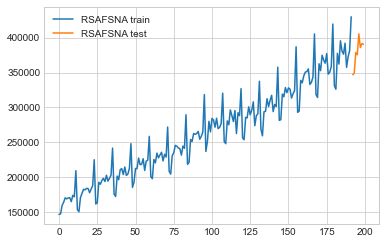

In [7]:
plt.plot(RSAFSNA_train, label='RSAFSNA train')
plt.plot(RSAFSNA_test, label='RSAFSNA test')
plt.legend()

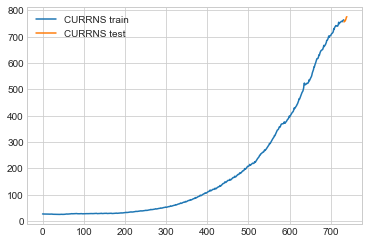

In [8]:
plt.plot(CURRNS_train, label='CURRNS train')
plt.plot(CURRNS_test, label='CURRNS test')
plt.legend()

Логарифмуємо дані

In [9]:
def log_series(series: pd.Series) -> pd.Series:
    res = np.log(series)
    res.name += ' LOG'
    return res

In [10]:
RSAFSNA_train_log, RSAFSNA_test_log = log_series(RSAFSNA_train), log_series(RSAFSNA_test)
CURRNS_train_log, CURRNS_test_log = log_series(CURRNS_train), log_series(CURRNS_test)

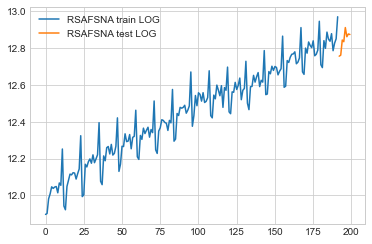

In [11]:
plt.plot(RSAFSNA_train_log, label='RSAFSNA train LOG')
plt.plot(RSAFSNA_test_log, label='RSAFSNA test LOG')
plt.legend()

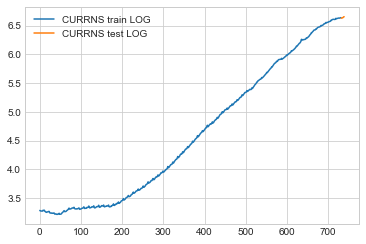

In [12]:
plt.plot(CURRNS_train_log, label='CURRNS train LOG')
plt.plot(CURRNS_test_log, label='CURRNS test LOG')
plt.legend()

### Моделі у вигляді тренду

In [13]:
def PolyFit(y: pd.Series, m: int) -> Dict[str, Union[np.array, pd.Series]]:
    """
    Fit polynomial model y(k) = a_0 + a_1*k + a_2*k^2 + ... + a_m*k^m
    """
    start_ind, stop_ind = y.index.start, y.index.stop
    Y = np.ones((len(y), m+1))
    for i in range(1, m+1):
        if i == 1:
            Y[:, i] = np.arange(start_ind, stop_ind)
        else:
            Y[:, i] = Y[:, 1]**i
    coefs = np.linalg.pinv(Y.T @ Y) @ Y.T @ y
    pred = pd.Series(Y @ coefs)
    pred.reindex(pd.RangeIndex(start_ind, stop_ind))
    return {'actual': y,
            'fitted': pred,
            'coefficients': coefs,
            'residuals': y - pred}

order = 1, equation: y(k) = 12.035758 + 0.004372*k^1 
R-squared            0.915591
Sum squared resid    1.039491
Durbin-Watson stat   1.945355
dtype: float64
--------------------------------------------------
order = 2, equation: y(k) = 12.005010 + 0.005343*k^1 - 0.000005*k^2 
R-squared            0.918632
Sum squared resid    1.002033
Durbin-Watson stat   2.018061
dtype: float64
--------------------------------------------------
order = 3, equation: y(k) = 11.973581 + 0.007344*k^1 - 0.000031*k^2 + 0.000000*k^3 
R-squared            0.920974
Sum squared resid    0.973192
Durbin-Watson stat   2.076999
dtype: float64
--------------------------------------------------


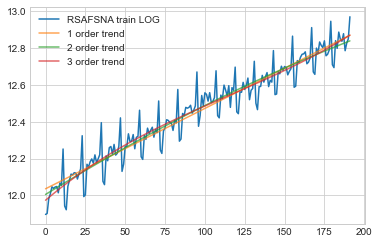

In [14]:
plt.plot(RSAFSNA_train_log, label='RSAFSNA train LOG')
for m in [1, 2, 3]:
    model = PolyFit(RSAFSNA_train_log, m)
    coef = model['coefficients']
    eq = f'y(k) = {coef[0]:.6f} '
    for i in range(1, m+1):
        eq += f'+ {coef[i]:.6f}*k^{i} ' if coef[i]>=0 else f'- {-coef[i]:.6f}*k^{i} '
    print(f'order = {m}, equation: {eq}')
    print(ModelEstimation(model['actual'].values, model['fitted'].values))
    print('-'*50)
    plt.plot(model['fitted'], label=f'{m} order trend', alpha=0.7)
plt.legend()

order = 1, equation: y(k) = 2.636182 + 0.005393*k^1 
R-squared             0.964580
Sum squared resid    34.902532
Durbin-Watson stat    0.001436
dtype: float64
--------------------------------------------------
order = 2, equation: y(k) = 3.039489 + 0.002078*k^1 + 0.000005*k^2 
R-squared             0.988945
Sum squared resid    10.893677
Durbin-Watson stat    0.004413
dtype: float64
--------------------------------------------------
order = 3, equation: y(k) = 0.000321 + 0.031336*k^1 - 0.000072*k^2 + 0.000000*k^3 
R-squared              1.886665
Sum squared resid    518.145966
Durbin-Watson stat     0.000275
dtype: float64
--------------------------------------------------


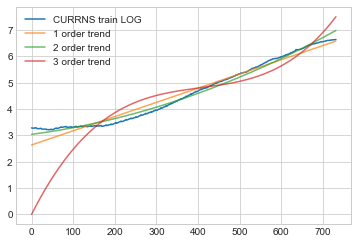

In [15]:
plt.plot(CURRNS_train_log, label='CURRNS train LOG')
for m in [1, 2, 3]:
    model = PolyFit(CURRNS_train_log, m)
    coef = model['coefficients']
    eq = f'y(k) = {coef[0]:.6f} '
    for i in range(1, m+1):
        eq += f'+ {coef[i]:.6f}*k^{i} ' if coef[i]>=0 else f'- {-coef[i]:.6f}*k^{i} '
    print(f'order = {m}, equation: {eq}')
    print(ModelEstimation(model['actual'].values, model['fitted'].values))
    print('-'*50)
    plt.plot(model['fitted'], label=f'{m} order trend', alpha=0.7)
plt.legend()